In [2]:
!pip install torchview
!pip install graphviz
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import math
from torchvision import models as torch_model
import numpy as np
import torch.nn as nn
import graphviz
from torchview import draw_graph
import os
from matplotlib import pyplot as plot
import time

In [3]:
batch_size = 128
epochs = 5
learning_rate = 0.001
num_classes = 10
dir_name = os.getcwd()
acc_array = []

In [4]:
def get_norm_params(dataset):
    mean = dataset.data.mean(axis=(0,1,2))/255
    std = dataset.data.std(axis=(0,1,2))/255
    return torch.tensor(mean).reshape(3, 1, 1), torch.tensor(std).reshape(3, 1, 1)

In [5]:
def get_data_loader(transforms_params):

   train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = transforms_params
)
   test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transforms_params
)
   train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
  )

   test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False)
   return train_data_loader, test_data_loader

In [6]:
loss_function = torch.nn.CrossEntropyLoss()
print('Training parameters: learning rate = {}, batch size = {}, number of epochs = {}'.format(learning_rate, batch_size, epochs))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Training parameters: learning rate = 0.001, batch size = 128, number of epochs = 5


device(type='cuda', index=0)

In [7]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

In [8]:
def train(Network, train_data_loader, test_data_loader, optimizer):
    for epoch in range(epochs):
        start = time.time()
        losses = []
        for i, (images, labels) in enumerate(train_data_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = Network(images)
            loss = loss_function(outputs, labels)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        duration = time.time() - start
        print('Epoch[{}]: loss = {}, accuracy = {}, time = {}'.format(epoch, torch.stack(losses).mean(), get_accuracy(Network,train_data_loader, device), duration))
    acc = get_accuracy(Network,test_data_loader, device)
    print('Test accuracy: {}'.format(acc))
    return acc

In [9]:
def show_Network(Network):
  graphviz.set_jupyter_format('png')
  model_graph = draw_graph(Network, input_size=(1,3,32,32), expand_nested=True)
  model_graph.visual_graph

In [10]:
def FreezeLayers(Network, train_data_loader, test_data_loader, upd_layers):
  for params in Network.parameters():
    params.requires_grad = False
  Network.fc = torch.nn.Linear(Network.fc.in_features, upd_layers)
  return Network

In [11]:
def ModLastLAyers(Network, train_data_loader, test_data_loader, upd_layers):
    for params in Network.parameters():
     params.requires_grad = False
    Network.fc = torch.nn.Sequential(torch.nn.Linear(Network.fc.in_features, Network.fc.in_features//2), torch.nn.ReLU(), torch.nn.Linear(Network.fc.in_features//2, 10),)
    return Network


In [12]:
def get_first_ex(Network_type, weights):
  Network = Network_type(weights)
  transforms = weights.transforms()
  train_data_loader, test_data_loader = get_data_loader(transforms)
  Network.to(device)
  Network = FreezeLayers(Network, train_data_loader, test_data_loader, num_classes)
  Network.to(device)
  optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)
  acc = train(Network, train_data_loader, test_data_loader, optimizer)
  print(Network)
  show_Network(Network)
  return acc

In [13]:
def get_second_ex(Network_type, weights):
  Network = Network_type(weights)
  transforms = weights.transforms()
  train_data_loader, test_data_loader = get_data_loader(transforms)
  Network = FreezeLayers(Network, train_data_loader, test_data_loader, num_classes)
  Network.to(device)
  optimizer = torch.optim.Adam(Network.parameters(), lr = learning_rate)
  acc = train(Network, train_data_loader, test_data_loader, optimizer)
  print(Network)
  show_Network(Network)
  return acc

In [38]:
def show_exp_result(acc_array_, type_array_):
  results = {}
  for i in range(len(acc_array_)):
    results[type_array[i]] = acc_array[i].cpu()
  print(results)
  fig = plot.figure(figsize = (25, 6))
  plot.bar(results.keys(), results.values())
  plot.xlabel("Models experiments")
  plot.ylabel("Test accuracy")
  plot.title("Comparison of architectures modifications")
  for i in range(len(acc_array_)):
        plot.text(i, acc_array[i].cpu() + 0.01, f'{int(acc_array[i].cpu() * 100)} %', ha='center')
  plot.show()

In [15]:
acc_array.append(get_first_ex(torch_model.googlenet, torch_model.GoogLeNet_Weights.DEFAULT))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 123MB/s]


100%|██████████| 170498071/170498071 [00:03<00:00, 43894188.62it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Epoch[0]: loss = 1.0507889986038208, accuracy = 0.740399956703186, time = 151.07927131652832
Epoch[1]: loss = 0.7548103928565979, accuracy = 0.7576999664306641, time = 136.13887357711792
Epoch[2]: loss = 0.7141134142875671, accuracy = 0.7623400092124939, time = 134.78494906425476
Epoch[3]: loss = 0.6970003247261047, accuracy = 0.764959990978241, time = 134.6344394683838
Epoch[4]: loss = 0.681117832660675, accuracy = 0.7666800022125244, time = 134.95319509506226
Test accuracy: 0.7483999729156494
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [16]:
acc_array.append(get_second_ex(torch_model.googlenet, torch_model.GoogLeNet_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 1.0363481044769287, accuracy = 0.7421799898147583, time = 144.1657989025116
Epoch[1]: loss = 0.7499765753746033, accuracy = 0.7568999528884888, time = 135.60365748405457
Epoch[2]: loss = 0.7116348147392273, accuracy = 0.7662999629974365, time = 128.16252756118774
Epoch[3]: loss = 0.6917943954467773, accuracy = 0.7662400007247925, time = 131.526593208313
Epoch[4]: loss = 0.6846444010734558, accuracy = 0.7664200067520142, time = 127.21467280387878
Test accuracy: 0.7525999546051025
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm

In [17]:
acc_array.append(get_first_ex(torch_model.resnet50, torch_model.ResNet50_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9356487989425659, accuracy = 0.7798199653625488, time = 161.21310663223267
Epoch[1]: loss = 0.6375657916069031, accuracy = 0.8083999752998352, time = 161.35025310516357
Epoch[2]: loss = 0.5757443904876709, accuracy = 0.8209199905395508, time = 163.50632047653198
Epoch[3]: loss = 0.5406995415687561, accuracy = 0.8278999924659729, time = 163.0914273262024
Epoch[4]: loss = 0.5119062066078186, accuracy = 0.837939977645874, time = 163.23579454421997
Test accuracy: 0.8039999604225159
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [18]:
acc_array.append(get_second_ex(torch_model.resnet50, torch_model.ResNet50_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9332679510116577, accuracy = 0.782039999961853, time = 162.60333466529846
Epoch[1]: loss = 0.6402639746665955, accuracy = 0.8088200092315674, time = 163.12183594703674
Epoch[2]: loss = 0.5762150883674622, accuracy = 0.8214199542999268, time = 163.1414930820465
Epoch[3]: loss = 0.537026584148407, accuracy = 0.8302599787712097, time = 161.37162065505981
Epoch[4]: loss = 0.512030839920044, accuracy = 0.8352400064468384, time = 161.6544327735901
Test accuracy: 0.8053999543190002
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
 

In [19]:
acc_array.append(get_first_ex(torch_model.resnet34, torch_model.ResNet34_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9248032569885254, accuracy = 0.7740399837493896, time = 131.93745636940002
Epoch[1]: loss = 0.649365246295929, accuracy = 0.7902799844741821, time = 132.70159935951233
Epoch[2]: loss = 0.6086506247520447, accuracy = 0.7945399880409241, time = 126.34254264831543
Epoch[3]: loss = 0.5877285599708557, accuracy = 0.8055799603462219, time = 132.4329059123993
Epoch[4]: loss = 0.5776138305664062, accuracy = 0.8067399859428406, time = 126.32348799705505
Test accuracy: 0.7856000065803528
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [20]:
acc_array.append(get_second_ex(torch_model.resnet34, torch_model.ResNet34_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.9208232164382935, accuracy = 0.7804999947547913, time = 132.28295254707336
Epoch[1]: loss = 0.6504387855529785, accuracy = 0.7861799597740173, time = 132.02666902542114
Epoch[2]: loss = 0.6081138849258423, accuracy = 0.7992799878120422, time = 132.56187462806702
Epoch[3]: loss = 0.5899880528450012, accuracy = 0.8068199753761292, time = 131.59804391860962
Epoch[4]: loss = 0.5777966380119324, accuracy = 0.8079999685287476, time = 132.8147304058075
Test accuracy: 0.7893999814987183
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [21]:
acc_array.append(get_first_ex(torch_model.shufflenet_v2_x2_0, torch_model.ShuffleNet_V2_X2_0_Weights.DEFAULT))

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 113MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.7916254997253418, accuracy = 0.8249199986457825, time = 132.45191025733948
Epoch[1]: loss = 0.5145546793937683, accuracy = 0.8474599719047546, time = 128.39315605163574
Epoch[2]: loss = 0.4558810293674469, accuracy = 0.8565399646759033, time = 128.51071047782898
Epoch[3]: loss = 0.42551401257514954, accuracy = 0.8664999604225159, time = 128.73163676261902
Epoch[4]: loss = 0.4015139937400818, accuracy = 0.8675599694252014, time = 129.47793292999268
Test accuracy: 0.8412999510765076
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
       

In [22]:
acc_array.append(get_second_ex(torch_model.shufflenet_v2_x2_0, torch_model.ShuffleNet_V2_X2_0_Weights.DEFAULT))

Files already downloaded and verified
Files already downloaded and verified
Epoch[0]: loss = 0.7924365997314453, accuracy = 0.8258799910545349, time = 123.51353025436401
Epoch[1]: loss = 0.5139058828353882, accuracy = 0.8455199599266052, time = 123.79772877693176
Epoch[2]: loss = 0.45590585470199585, accuracy = 0.8605999946594238, time = 129.89112830162048
Epoch[3]: loss = 0.4254096746444702, accuracy = 0.8656599521636963, time = 124.21943616867065
Epoch[4]: loss = 0.40267065167427063, accuracy = 0.8737199902534485, time = 125.34006810188293
Test accuracy: 0.8460999727249146
ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
      

In [23]:
acc_array

[tensor(0.7484, device='cuda:0'),
 tensor(0.7526, device='cuda:0'),
 tensor(0.8040, device='cuda:0'),
 tensor(0.8054, device='cuda:0'),
 tensor(0.7856, device='cuda:0'),
 tensor(0.7894, device='cuda:0'),
 tensor(0.8413, device='cuda:0'),
 tensor(0.8461, device='cuda:0')]

In [24]:
type_array = ("GoogleNet First", "GoogleNet Second", "ResNet50 First", "ResNet50 Second", "ResNet34 First", "ResNet34 Second", "Shufflenet_v2_x2_0 First", "Shufflenet_v2_x2_0 Second")

{'GoogleNet First': tensor(0.7484), 'GoogleNet Second': tensor(0.7526), 'ResNet50 First': tensor(0.8040), 'ResNet50 Second': tensor(0.8054), 'ResNet34 First': tensor(0.7856), 'ResNet34 Second': tensor(0.7894), 'Shufflenet_v2_x2_0 First': tensor(0.8413), 'Shufflenet_v2_x2_0 Second': tensor(0.8461)}


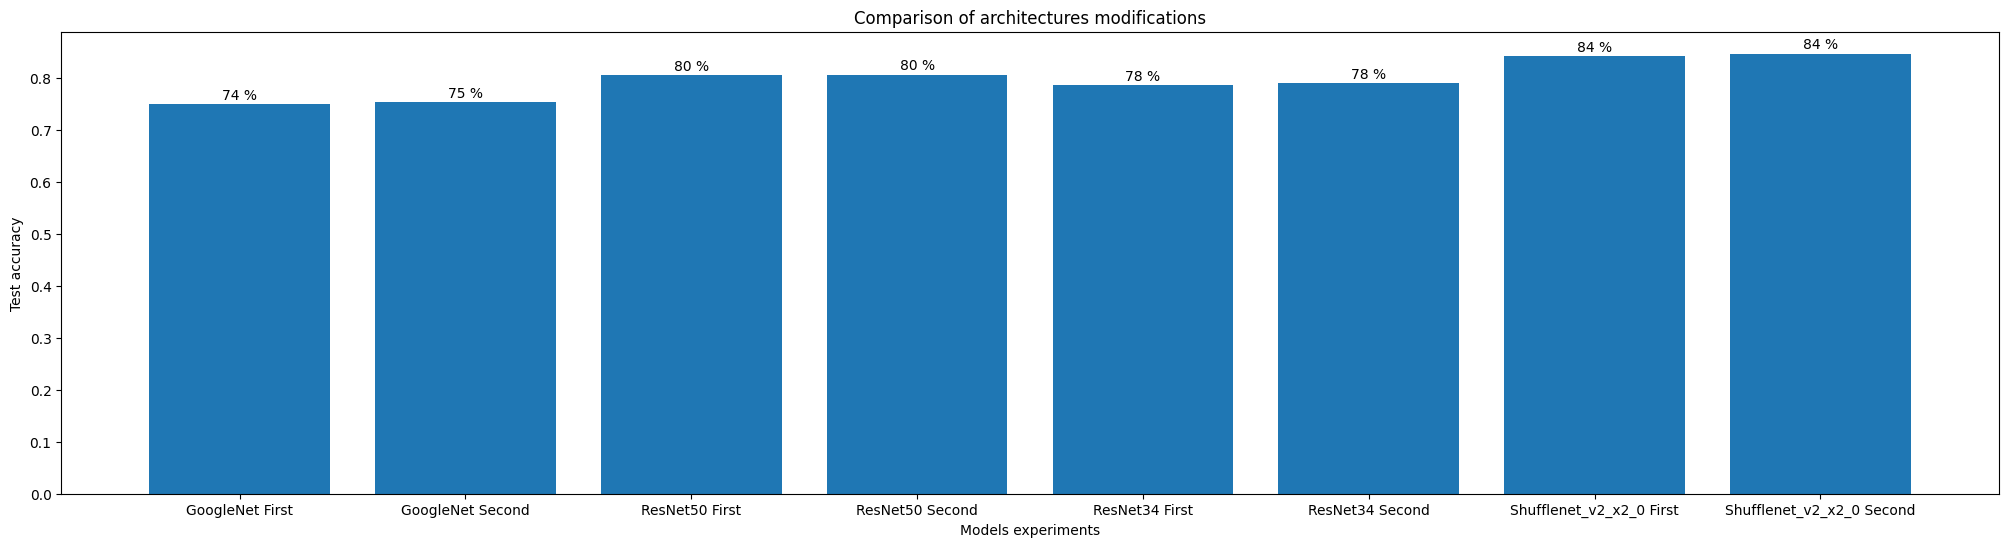

In [39]:
show_exp_result(acc_array, type_array)